In [33]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df, show_pathways_in_ranked_genes
from dokdonia.utils import take_average_values, saveToPickleFile

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Load counts

In [2]:
min_count = 10

counts = pd.read_csv(data_dir / 'counts' / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)

## Load KEGG pathways and genome annotations

In [3]:
gbk = GenomeGBK(data_dir / 'genome' / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
# gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 785 genes


# Find DE genes

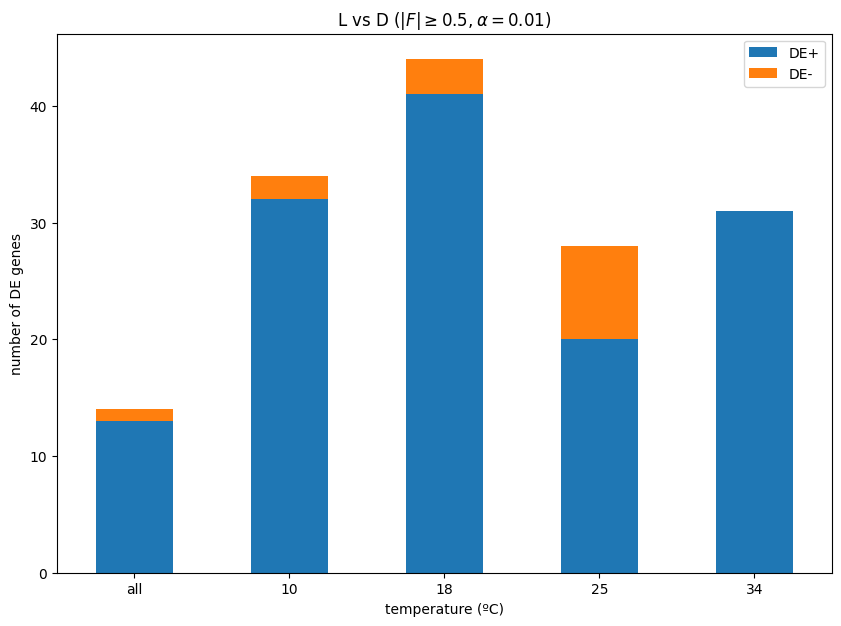

In [4]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [34]:
DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }

# Save to pickle
saveToPickleFile(DELD, results_dir / "deseq_results" / "DELD.pkl")

In [6]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


There are 1930 out of 2877 genes (67.08376781369482 %) which are DE across all temperature values


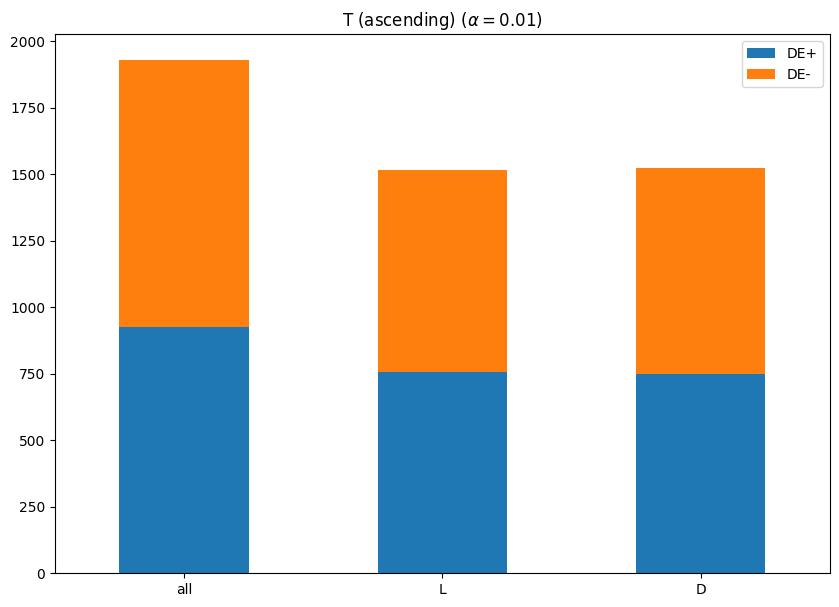

In [7]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes ({100 * len(DE_genes_across_T)/counts.shape[0]} %) which are DE across all temperature values")

## Get DeSeq2 normalized counts

In [39]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")
deseq2_counts.to_csv(data_dir / "processed" / "DokdoniaMED134_DS2.tsv", sep="\t", index=False)
deseq2_counts.head()

## Compute Transcript / cell values

In [9]:
sample_meta = pd.read_excel(data_dir / "normalization" / "Datos_Dokdonia_9Jun23.xlsx")
sample_meta["Sample"] = sample_meta['Light/Dark'] + '_' + sample_meta['Temperature'].astype(str) + '_' + sample_meta['Replicate']
sample_meta.head()

,Temperature,Light/Dark,Replicate,Total biovolume (um3),Total abundance (cells),Avg_Standard_ratio,Sample
0,10,L,R1,2.294207e+08,7.609607e+08,7128.171978,L_10_R1
1,10,L,R2,1.803365e+08,5.434251e+08,22976.436275,L_10_R2
2,10,L,R3,1.960539e+08,6.095364e+08,20778.875834,L_10_R3
3,10,D,R1,1.841892e+08,5.789344e+08,12210.079577,D_10_R1
4,10,D,R2,1.900776e+08,5.737051e+08,18207.999370,D_10_R2


In [38]:
TC = DE.get_transcript_cell(counts, sample_meta, ["D_25_R1"]).set_index("index")
TC.to_csv(data_dir / "processed" / "DokdoniaMED134_TC.tsv", sep="\t")
TC.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_25_R2,D_25_R3,D_34_R1,D_34_R2,D_34_R3,...,L_10_R3,L_18_R1,L_18_R3,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
index,,,,,,,,,,,,,,,,,,,,,
MED134_07389,0.273608,0.362633,0.314843,1.400648,2.466851,1.168274,1.291959,1.606026,1.354968,1.020768,...,0.408360,0.986825,0.569171,0.853985,1.864628,0.917180,0.846804,0.944030,1.231293,1.381038
MED134_07384,0.032838,0.049352,0.036875,0.190266,0.353293,0.162741,0.178013,0.235689,0.193355,0.163183,...,0.054271,0.133927,0.071381,0.117324,0.247419,0.131755,0.115207,0.144760,0.193405,0.186689
MED134_07379,0.071708,0.105337,0.077766,0.330129,0.636734,0.273291,0.346903,0.419416,0.335165,0.274610,...,0.111541,0.220965,0.127431,0.196782,0.402950,0.211308,0.217327,0.232085,0.325291,0.330180
MED134_07374,0.041907,0.067411,0.033359,0.160491,0.303905,0.119682,0.142566,0.151663,0.133189,0.077265,...,0.054748,0.110957,0.060803,0.077639,0.160626,0.086416,0.088775,0.094333,0.118390,0.127110
MED134_07369,0.044016,0.063792,0.050157,0.172611,0.306886,0.124735,0.129111,0.177424,0.134795,0.077241,...,0.066100,0.134110,0.082149,0.080215,0.185833,0.093155,0.117812,0.108562,0.122452,0.122979


## Compare median values between counts, DeSeq2-normalized counts, and transcript / cell values

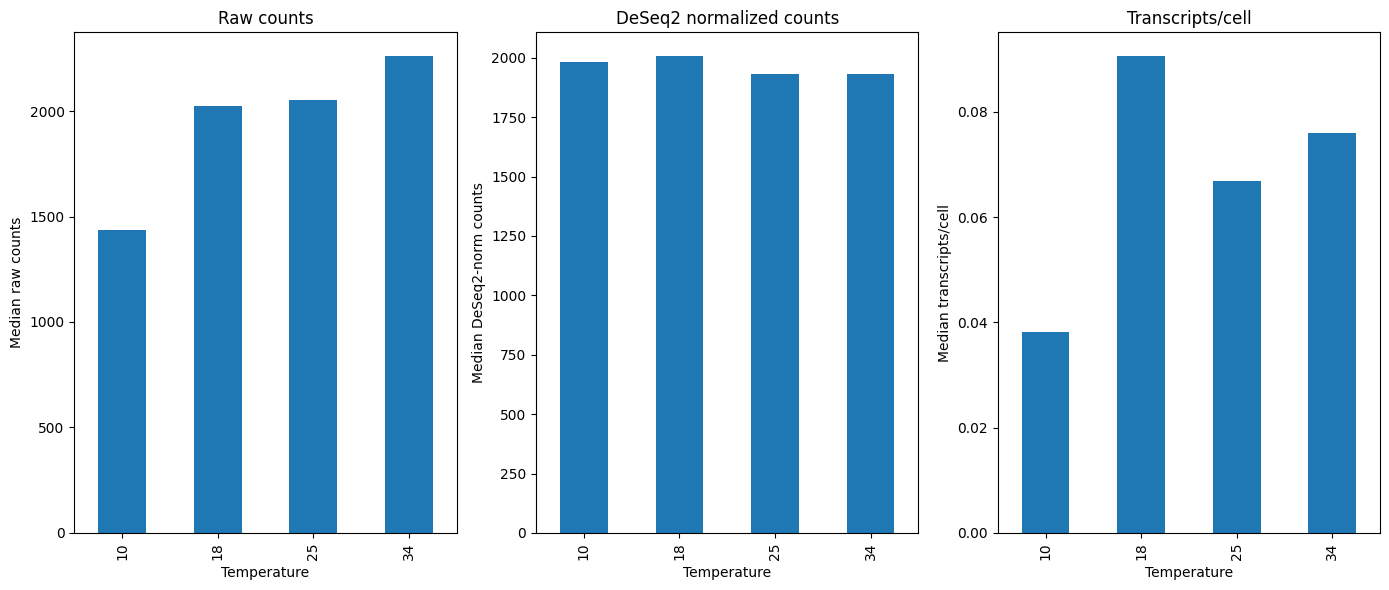

In [11]:
# Take median values across replicates
counts_avg = take_average_values(counts.set_index("index")).median()
TC_avg = take_average_values(TC, method='median')
DS2_avg = take_average_values(deseq2_counts.set_index("index")).median()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

ax0 = counts_avg.plot(kind='bar', ax=axes[0], title='Raw counts')
ax0.set_xlabel('Temperature')
ax0.set_ylabel('Median raw counts')

ax1 = DS2_avg.plot(kind='bar', ax=axes[1], title='DeSeq2 normalized counts')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Median DeSeq2-norm counts')

ax2 = TC_avg.median().plot(kind='bar', ax=axes[2], title='Transcripts/cell')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Median transcripts/cell')

plt.tight_layout()
plt.show()

## Compute differences in median expression between conditions

In [12]:
TC_avg.median() / TC_avg.median().median()

Temperature
10    0.536284
18    1.269574
25    0.936103
34    1.063897
dtype: float64

## Remove Light/Dark DE genes from datasets

In [13]:
# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) #&
    # (counts["index"].isin(DE_genes_across_T))
    )]

# Remove light-dark DE genes from Deseq2 dataset
deseq2_counts_noDE = deseq2_counts.loc[(
    (~deseq2_counts["index"].isin(DE_all_T)) #&
    # (deseq2_counts["index"].isin(DE_genes_across_T))
    )]

# Remove light-dark DE genes from TC dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T)) #&
    # (TC_new.index.isin(DE_genes_across_T))
    )]

# Find clusters based on expression pattern across temperatures: DeSeq2-normalized counts

In [14]:
# Using Deseq2 data
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_DS2Z = CA.getGeneClusters(deseq2_counts_noDE.set_index("index"),path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data_DS2Z = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Wednesday 05 July 2023 (12:05:30)                    |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

In [15]:
# Print total number of genes contained in the sum of all clusters
total_genes_in_clusters = [g for cluster in clusters_DS2Z.values() for g in cluster]
print(f'Total number of genes in all clusters: {len(total_genes_in_clusters)}')
# Print fraction of total genes in cluisters versus total number of genes
print(f'Fraction of total genes in clusters: {len(total_genes_in_clusters) / len(plot_cluster_data_DS2Z)}')


Total number of genes in all clusters: 1204
Fraction of total genes in clusters: 0.42053789731051344


In [16]:
# Rename clusters to group by pattern
cluster_map = {
    "C0": "C0",
    "C1": "C2",
    "C2": "C3",
    "C3": "C1",
    "C4": "C4"
}

clusters_DS2Z = {
    cluster_map[cluster_id]: cluster
    for cluster_id, cluster in clusters_DS2Z.items()
    if cluster_id != "C5"
}

clusters_DS2Z = dict(sorted(clusters_DS2Z.items(), key=lambda x: x[0]))

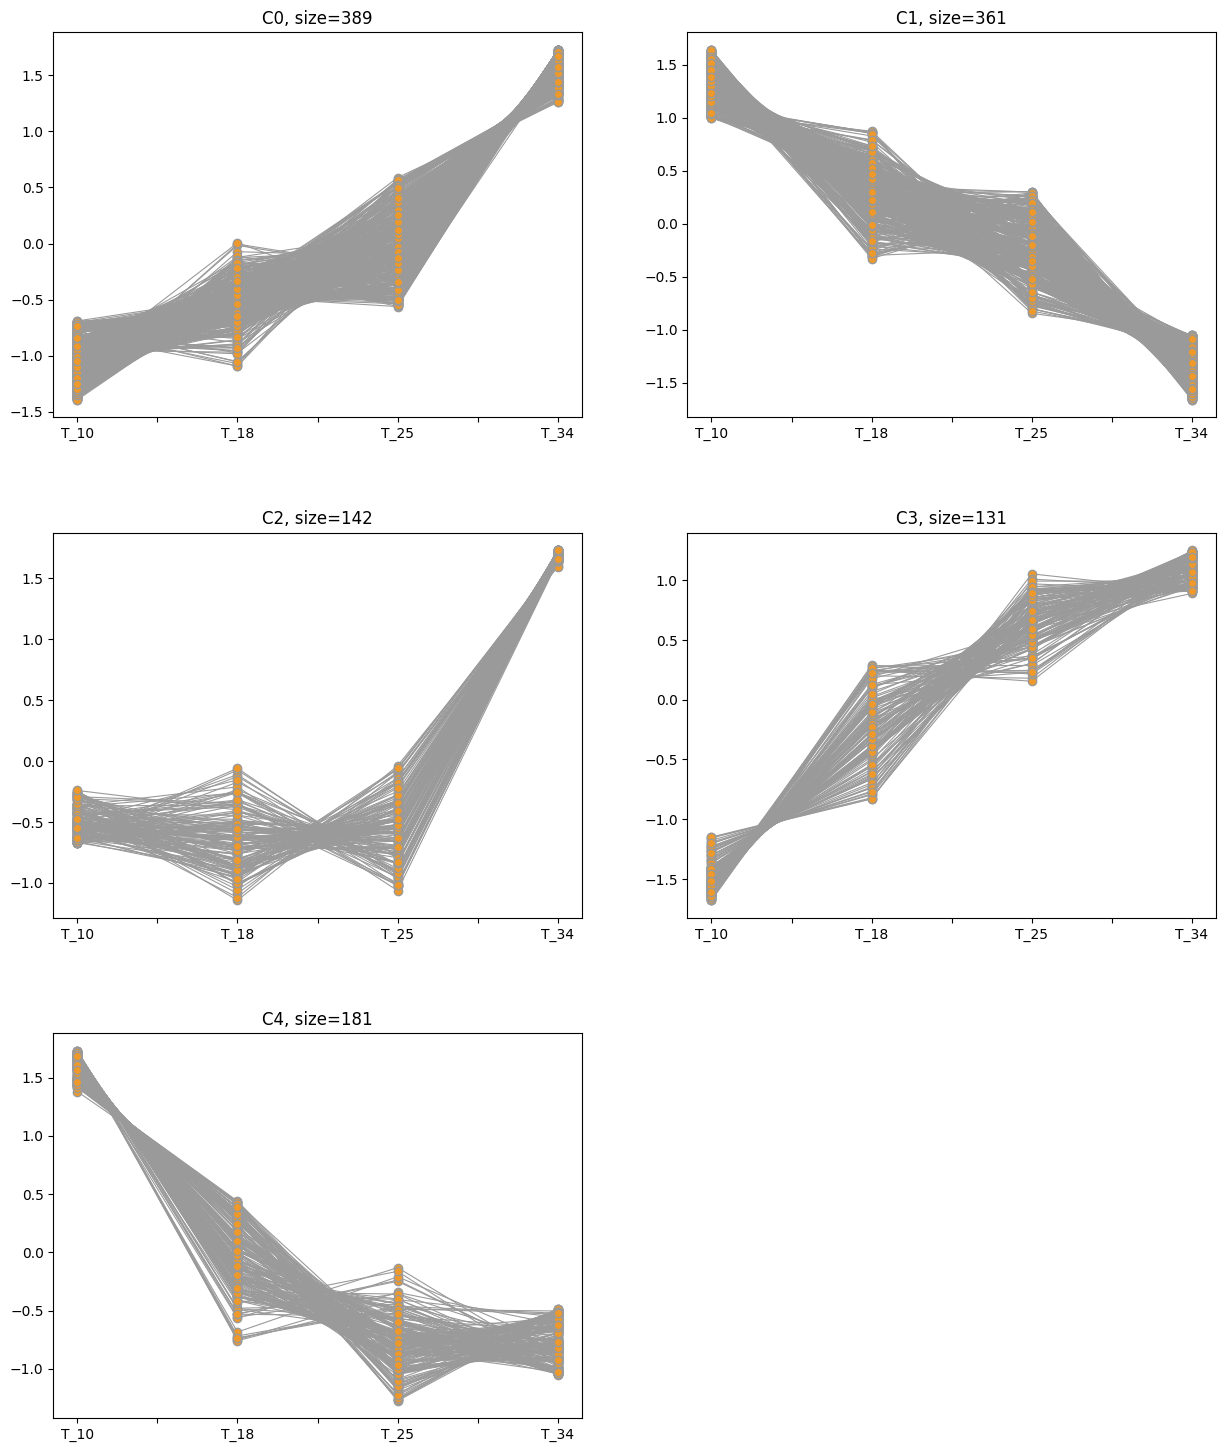

In [17]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z)

## Find genes in clusters that are not DE according to the LRT test of Deseq2

There are about 790 DE genes across temperatures according to LRT, alpha=0.01, but over 1200 within the clusters. What happens with the genes that are not DE according to LRT but are in the clusters and do follow non random patterns?

In [18]:
print(f"There are {len(DE_genes_across_T)} genes that are differentially expressed across all temperatures.")

There are 1930 genes that are differentially expressed across all temperatures.


In [19]:
# DE_genes_across_T
clusters_DS2Z_noDE = {
    cluster_id: [g for g in cluster if g not in DE_genes_across_T]
    for cluster_id, cluster in clusters_DS2Z.items()
}

# Genes that are not DE across temperatures AND not included in any cluster
not_in_clusters_and_no_DE = [
    g for g in deseq2_counts_noDE.set_index("index").index
    if g not in DE_genes_across_T and g not in total_genes_in_clusters
]

print(f"There are {len(not_in_clusters_and_no_DE)} genes that are not DE across temperatures AND not included in any cluster.")

There are 860 genes that are not DE across temperatures AND not included in any cluster.


## Plot genes that are included in clusters but are not DE across temperatures

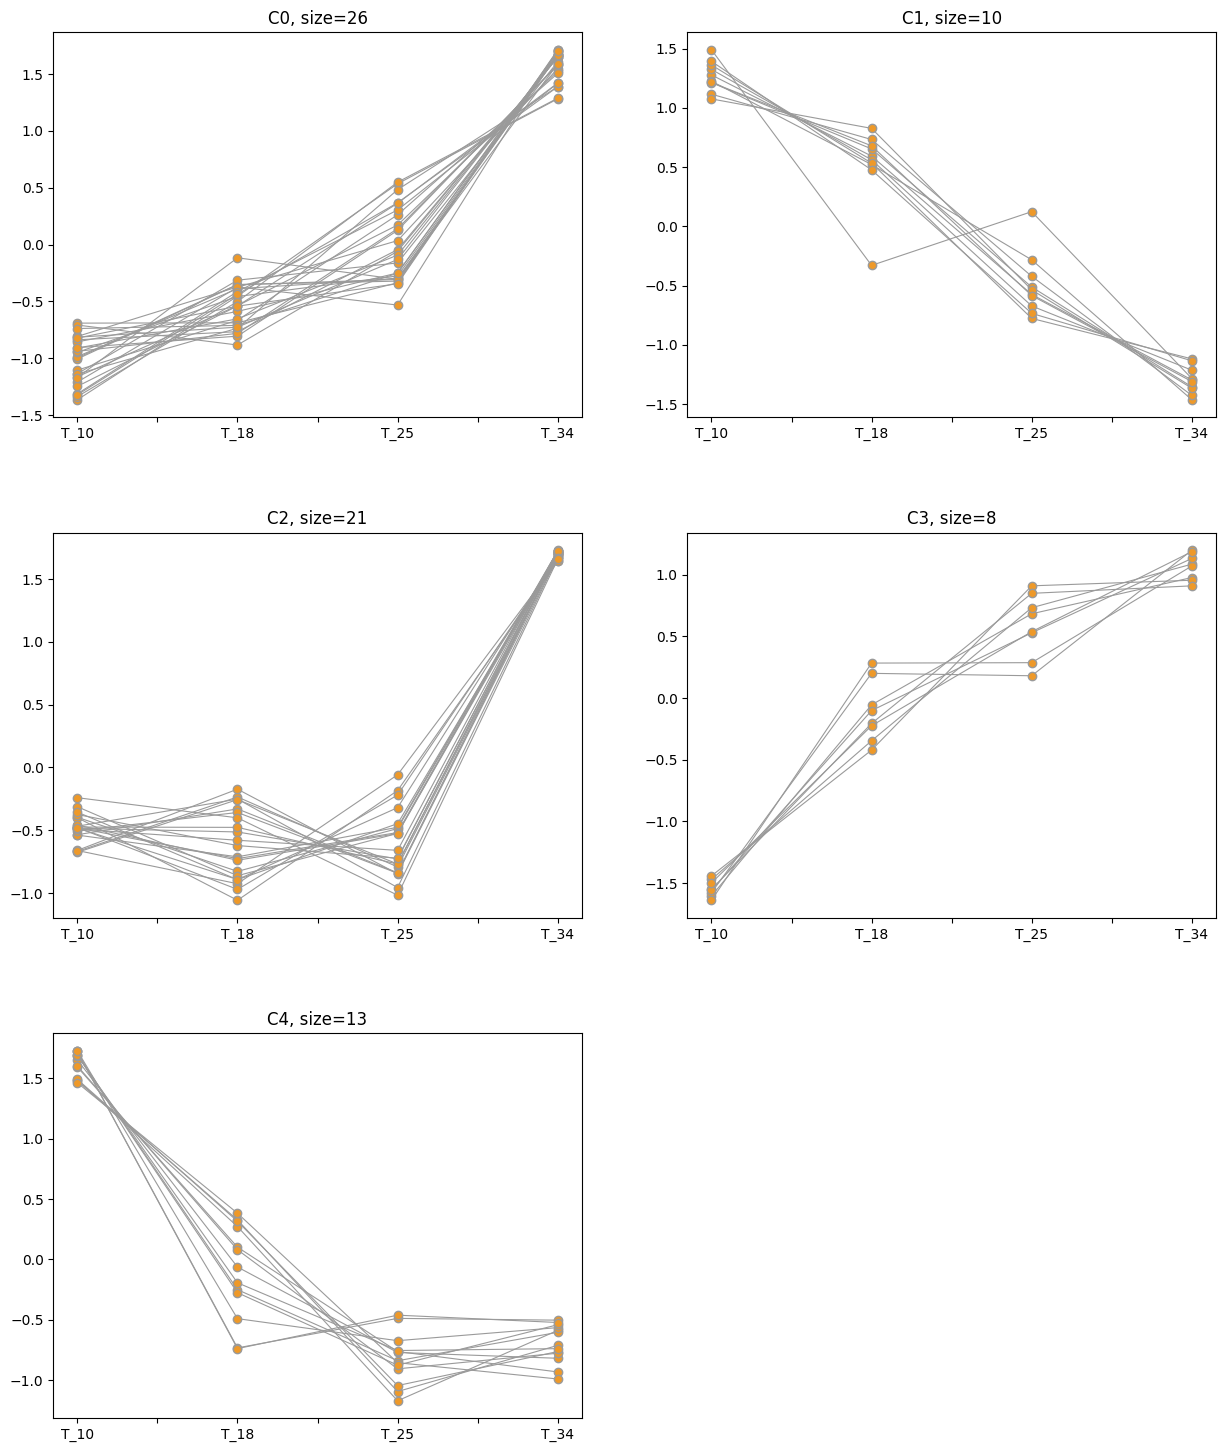

In [20]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z_noDE)

Well it does look like DE to me...

## Annotate and rank genes within clusters

In [21]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES"

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='index')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_DS2Z, cluster_data, method="median")

In [22]:
if not (results_dir / "pathways").exists():
   (results_dir / "pathways").mkdir(exist_ok=False)

no_kegg_pathway = []
ranked_clusters = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.insert(0, "cluster", cluster_id)
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}.csv")
    ranked_clusters.append(ranked_df)

merged_ranked_clusters = pd.concat(ranked_clusters).sort_values(by="value", ascending=False)
merged_ranked_clusters.to_csv(results_dir / "pathways" / "ranked_clusters.csv")
print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[85.34704370179949, 63.43490304709141, 85.91549295774648, 84.73282442748092, 74.03314917127072]
78.69268266107781


## Ranked lists among the global 10% by expression

In [23]:
percent_cutoff = 10

filtered_ranked_clusters = {}

all_genes_expression = {gene: expr for cluster in ranked_clusters_avg_expr.values() for gene, expr in cluster.items()}

sorted_all_genes_expression = sorted(all_genes_expression.items(), key=lambda x:x[1], reverse=True)
sorted_all_genes_expression = dict(sorted_all_genes_expression)

cutoff_position = int( (10 / 100) * len(sorted_all_genes_expression) )
cutoff_value = list(sorted_all_genes_expression.values())[cutoff_position]
print(f"Cutoff average expression value of: {cutoff_value} Deseq2 values")
top_genes = list(sorted_all_genes_expression.keys())[:cutoff_position]

for cluster_id, cluster in ranked_clusters_avg_expr.items():
    filtered_ranked_clusters[cluster_id] = {gene: expr for gene, expr in cluster.items() if gene in top_genes}

Cutoff average expression value of: 12497.385577766818 Deseq2 values


In [24]:
# Cluster IDs in the top 10% of genes
top_10_ranked = merged_ranked_clusters.loc[merged_ranked_clusters.value > cutoff_value, :]
top_10_ranked.cluster.value_counts()

C1    80
C4    20
C0    11
C3     5
C2     4
Name: cluster, dtype: int64

Genes in the top 10% by expression (DeSeq2-normalized) tend to located in clusters with a downward pattern, negativaly correlated with temperature (clusters C1 and C4.)

## Rank temperature - independent genes and assign pathways

In [25]:
from dokdonia.utils import sort_dict_by_values

deseq2_avg = take_average_values(deseq2_counts.set_index("index"), method="median")

temp_indep_ranked_genes = {
    gene_id: deseq2_avg.loc[gene_id].median()
    for gene_id in not_in_clusters_and_no_DE
}

temp_indep_ranked_genes = sort_dict_by_values(temp_indep_ranked_genes, reverse=True)

# Add pathways
temp_indep_pathways = show_pathways_in_ranked_genes(
    temp_indep_ranked_genes, gbk, gene_pathways, gene_systems, n=None
    )

# Save to csv in pathways folder
temp_indep_pathways.to_csv(
    results_dir / "pathways" / "temp_indep_pathways.csv"
    )

temp_indep_pathways.head()

,product,subsystem,system,value
gene_id,,,,
MED134_12381,TonB dependent/ligand-gated channel,Unspecified,Unspecified,564740.063149
MED134_12376,hypothetical protein,Unspecified,Unspecified,303786.809413
MED134_10820,TonB dependent/ligand-gated channel,Unspecified,Unspecified,205742.824659
MED134_12371,hypothetical protein,Unspecified,Unspecified,205134.015810
MED134_02385,translation elongation factor Tu,Unspecified,Unspecified,141586.411804


In [26]:
temp_indep_pathways.loc[temp_indep_pathways.value > cutoff_value, "system"].value_counts()

Unspecified                                                                                                                                            39
[09102 Energy metabolism]                                                                                                                               5
[09122 Translation]                                                                                                                                     5
[09123 Folding, sorting and degradation, 09131 Membrane transport, 09145 Cellular community - prokaryotes]                                              2
[09101 Carbohydrate metabolism, 09101 Carbohydrate metabolism, 09101 Carbohydrate metabolism, 09108 Metabolism of cofactors and vitamins]               2
[09103 Lipid metabolism]                                                                                                                                2
[09132 Signal transduction]                                                 

## Find fraction of unannotated genes in clusters

As a side note, which fraciton of genes in Dokdonia MED134 are unannotated??

In [27]:
lines = ["gene_id\tgene_name\tproduct\tkegg_pathway\n"]
for gene_id in counts["index"]:   
    gene_info = gbk.getGeneInfo(gene_id)
    gene_name = gene_info["gene"][0] if "gene" in gene_info else "unspecified"
    product = gene_info["product"][0]
    kegg_pathway = ",".join(gene_pathways[gene_id]) if gene_id in gene_pathways else "unspecified"
    lines.append(
        (
            f"{gene_id}\t"
            f"{gene_name}\t"
            f"{product}\t"
            f"{kegg_pathway}\n"
            )
        )
with open(results_dir / "pathways" / "gene_annotations.tsv", "w") as file:
    file.writelines(lines)


annot = pd.read_csv(results_dir / "pathways" / "gene_annotations.tsv", sep="\t").set_index("gene_id")

print(f"Fraction of genes with no KEGG annotation: {sum(annot.kegg_pathway == 'unspecified') / len(annot):.2%}")
print(f"Fraction of genes with no product annotation: {sum(annot['product'] == 'hypothetical protein') / len(annot):.2%}")
print(f"Fraction of genes with no gene name annotation: {sum(annot['gene_name'] == 'unspecified') / len(annot):.2%}")

kegg_cluster_repr = []
for cluster_id, cluster_genes in clusters_DS2Z.items():
    kegg_cluster_repr.append(
        sum(annot.loc[cluster_genes].kegg_pathway == "unspecified") / len(cluster_genes)
    )
# Print average fraction of genes with no KEGG annotation per cluster
print(f"Average fraction of genes with no KEGG annotation per cluster: {np.mean(kegg_cluster_repr):.2%}")


Fraction of genes with no KEGG annotation: 74.52%
Fraction of genes with no product annotation: 37.96%
Fraction of genes with no gene name annotation: 74.21%
Average fraction of genes with no KEGG annotation per cluster: 78.69%


## Enriched metabolic pathways in Deseq2 clusters

In [28]:
from dokdonia.utils import terminal_execute

print(res_id)
out_dir = results_dir / "enrichment_results"
out_dir.mkdir(exist_ok=True)

clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)

# Show enriched pathways
enrichment_results = pd.read_csv(out_dir / f"results_{res_id}.csv")

enrichment_results.Cluster = enrichment_results.Cluster.apply(lambda x: cluster_map[f"C{int(list(x)[-1]) - 1}"])
enrichment_results.set_index("Cluster", inplace=True)

# Write to csv file
enrichment_results.to_csv(out_dir / f"results_{res_id}.csv")
enrichment_results.head()

CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES



clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter



,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
Cluster,,,,,,,,,
C1,dok03010,Ribosome - Dokdonia sp. MED134,38/134,38/280,2.842714e-14,1.336076e-12,1.336076e-12,MED134_00530/MED134_00535/MED134_00540/MED134_...,38
C4,dok00220,Arginine biosynthesis - Dokdonia sp. MED134,9/47,10/280,4.651026e-07,2.092962e-05,1.860411e-05,MED134_03484/MED134_03489/MED134_11911/MED134_...,9
C4,dok01230,Biosynthesis of amino acids - Dokdonia sp. MED134,14/47,34/280,2.513563e-04,5.655517e-03,5.027127e-03,MED134_03484/MED134_03489/MED134_04314/MED134_...,14
C4,dok01100,Metabolic pathways - Dokdonia sp. MED134,38/47,169/280,1.007555e-03,1.511332e-02,1.343406e-02,MED134_01325/MED134_01365/MED134_02085/MED134_...,38
C4,dok00250,"Alanine, aspartate and glutamate metabolism - ...",7/47,13/280,1.905574e-03,2.143771e-02,1.905574e-02,MED134_01325/MED134_03484/MED134_03489/MED134_...,7


# Cluster Transcript / cell data

In [29]:
# Using Transcripts/cell
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TCZ = CA.getGeneClusters(TCnoDE,path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1e5)

# Plot clusters
plot_cluster_data_TCZ = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

# VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ)


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Wednesday 05 July 2023 (12:06:00)                    |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

## Merge clusters

Merge into 3 groups. Also add a new cluster formed by the genes that correlate negatively with temperature.

There are a total of 1531 clustered genes


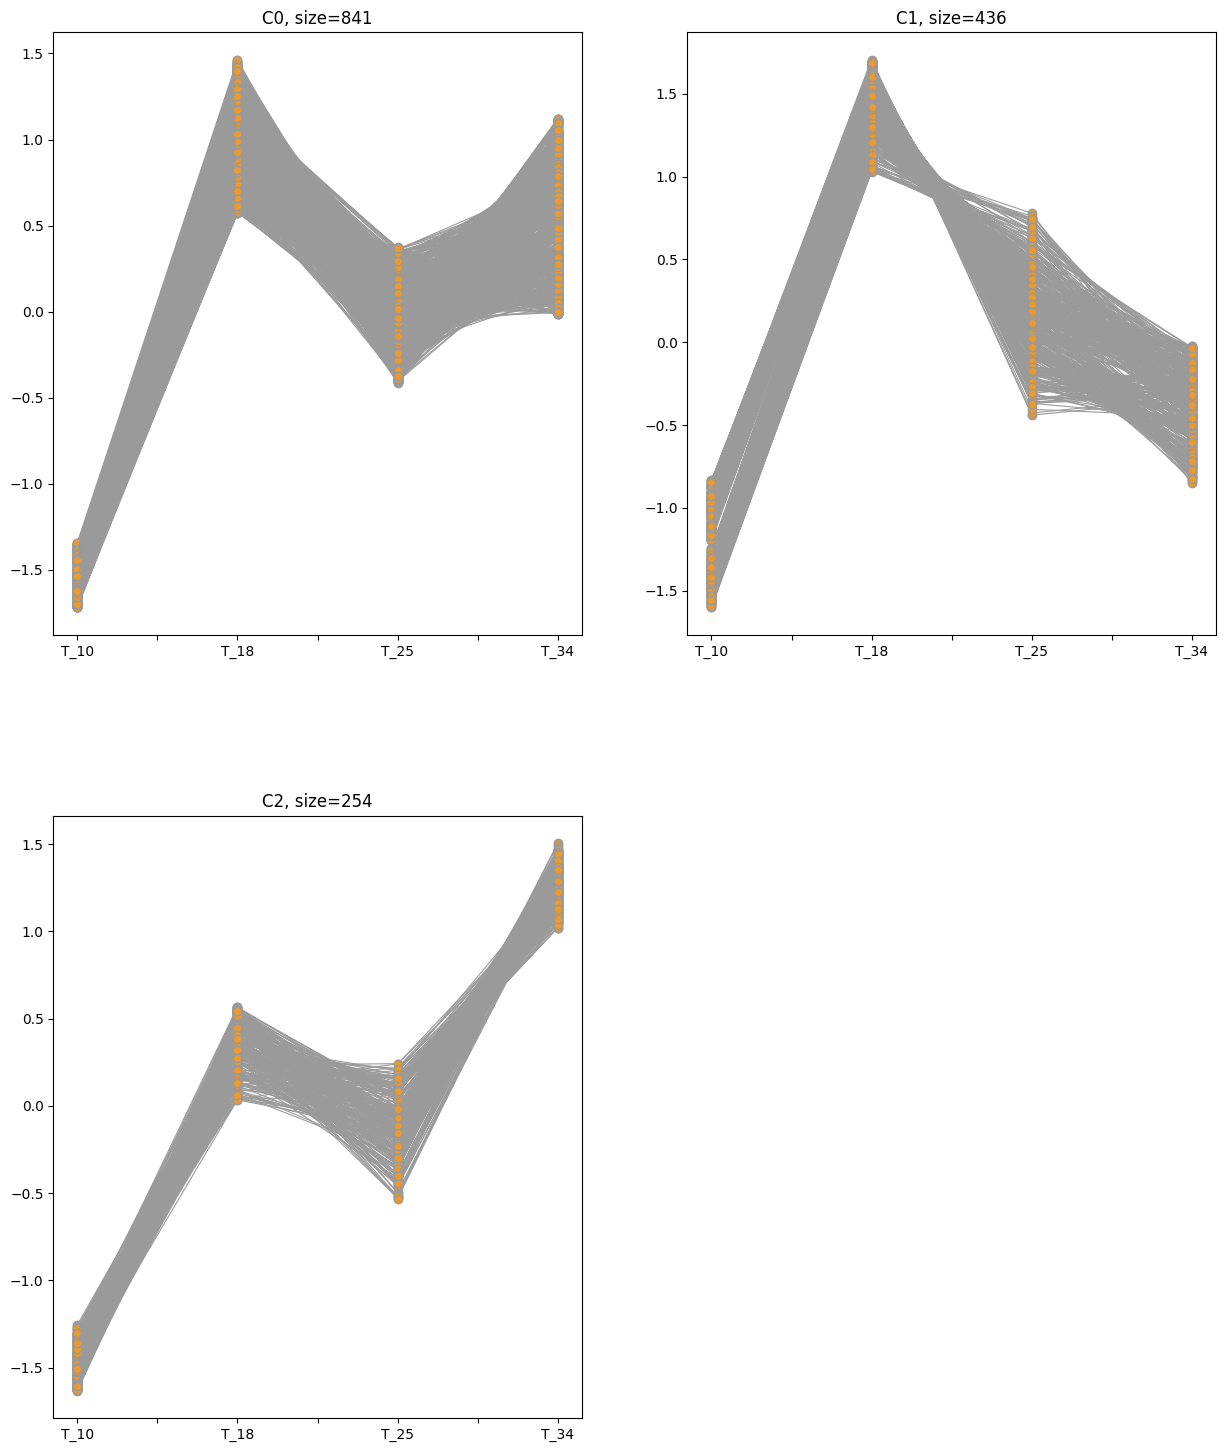

In [30]:
clusters_TCZ = {
    "C0": clusters_TCZ["C0"] + clusters_TCZ["C1"],
    "C1": clusters_TCZ["C2"] + clusters_TCZ["C3"],
    "C2": clusters_TCZ["C4"]
}

# Merge clusters in Clust output file
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clusters_TCZ.items() ]))
df = df.applymap(lambda x: "" if pd.isna(x) else x)

with open(results_dir / "clust" / f"{res_id}/Clusters_Objects_merged.tsv", "w+") as file:
    file.write("\t".join([f"{k} ({len(v)} genes)" for k,v in clusters_TCZ.items()]) + "\n")
    file.write("\t".join(["Genes" for _ in clusters_TCZ]) + "\n")

    for row in df.values:
        file.write("\t".join(row) + "\n")

n_genes_in_clusters = sum([len(c) for c in clusters_TCZ.values()])
print(f"There are a total of {n_genes_in_clusters} clustered genes")

VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ)

## Annotate and rank genes within clusters

In [31]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES"

cluster_data = (1 / 1e5) * pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='index')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_TCZ, cluster_data, method="median")


if not (results_dir / "pathways").exists():
   (results_dir / "pathways").mkdir(exist_ok=False)

no_kegg_pathway = []
ranked_clusters = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.insert(0, "cluster", cluster_id)
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}_TCZ.csv")
    ranked_clusters.append(ranked_df)

merged_ranked_clusters = pd.concat(ranked_clusters).sort_values(by="value", ascending=False)
merged_ranked_clusters.to_csv(results_dir / "pathways" / "ranked_clusters_TCZ.csv")
print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[73.2461355529132, 68.34862385321101, 86.61417322834646]
76.06964421149023
